# Steam Reviews Sentiment Analysis for PUBG: Battlegrounds using SVM

This notebook performs sentiment analysis on Steam reviews for PUBG: Battlegrounds using a Support Vector Machine (SVM) algorithm. We'll load the reviews from a parquet file, preprocess the text data, and train an SVM model to classify reviews as positive or negative.

In [1]:
# Import required libraries
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gerson
[nltk_data]     Leite\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Text Preprocessing
Before training our SVM model, we need to preprocess the review text by:
1. Converting to lowercase
2. Removing special characters and numbers
3. Removing stopwords
4. Tokenizing the text

In [2]:
def preprocess_text(text: str) -> str:
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a string
    return ' '.join(tokens)

In [4]:
# Load PUBG reviews from parquet file
reviews_df = pd.read_parquet('pubg-reviews.parquet')

# Display basic information about the dataset
print(f"Total reviews collected: {len(reviews_df)}")
print("\nSentiment distribution:")
print(reviews_df['sentiment'].value_counts())

# Preprocess reviews
print("\nPreprocessing reviews...")
reviews_df['processed_review'] = reviews_df['review'].apply(preprocess_text)

# Prepare features and labels
X = reviews_df['processed_review']
y = reviews_df['voted_up']  # True for positive, False for negative

Total reviews collected: 5000

Sentiment distribution:
sentiment
Negative    3312
Positive    1688
Name: count, dtype: int64

Preprocessing reviews...


## Training the SVM Model
Now we'll:
1. Convert text to TF-IDF features
2. Split the data into training and testing sets
3. Train the SVM model
4. Evaluate its performance

In [5]:
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (4000, 5000)
Testing data shape: (1000, 5000)


In [6]:
# Initialize and train the SVM model with probability estimation enabled
print("\nTraining SVM model...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2%}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Training SVM model...

Accuracy: 81.20%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87       673
    Positive       0.75      0.64      0.69       327

    accuracy                           0.81      1000
   macro avg       0.79      0.77      0.78      1000
weighted avg       0.81      0.81      0.81      1000


Accuracy: 81.20%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87       673
    Positive       0.75      0.64      0.69       327

    accuracy                           0.81      1000
   macro avg       0.79      0.77      0.78      1000
weighted avg       0.81      0.81      0.81      1000



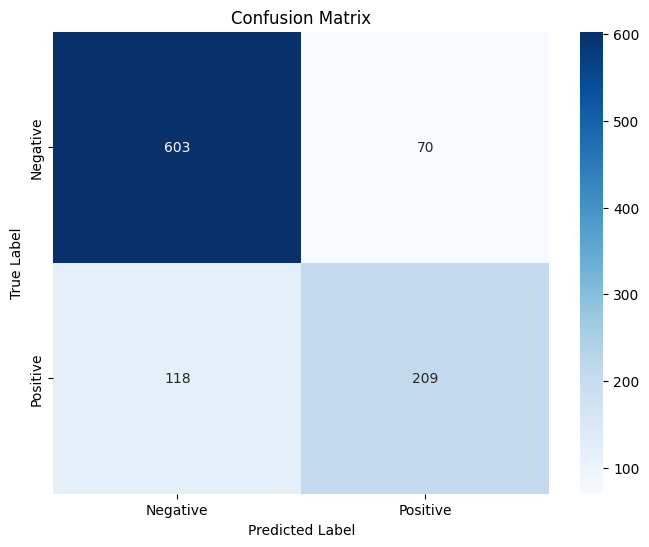

In [7]:
# Create a confusion matrix visualization
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Sentiment Analysis Results:
--------------------------------------------------------------------------------
Review: Lots of fun, but the matchmaking is terrible.
Sentiment: Positive
Confidence: Negative=31.01%, Positive=68.99%
--------------------------------------------------------------------------------
Review: It's okay, not the best but not the worst either.
Sentiment: Positive
Confidence: Negative=23.58%, Positive=76.42%
--------------------------------------------------------------------------------
Review: I had a lot of fun, but there are some issues that need fixing.
Sentiment: Positive
Confidence: Negative=16.54%, Positive=83.46%
--------------------------------------------------------------------------------
Review: While the game has potential, it suffers from numerous bugs.
Sentiment: Negative
Confidence: Negative=84.37%, Positive=15.63%
--------------------------------------------------------------------------------
Review: Best battle royale game ever, highly recommen

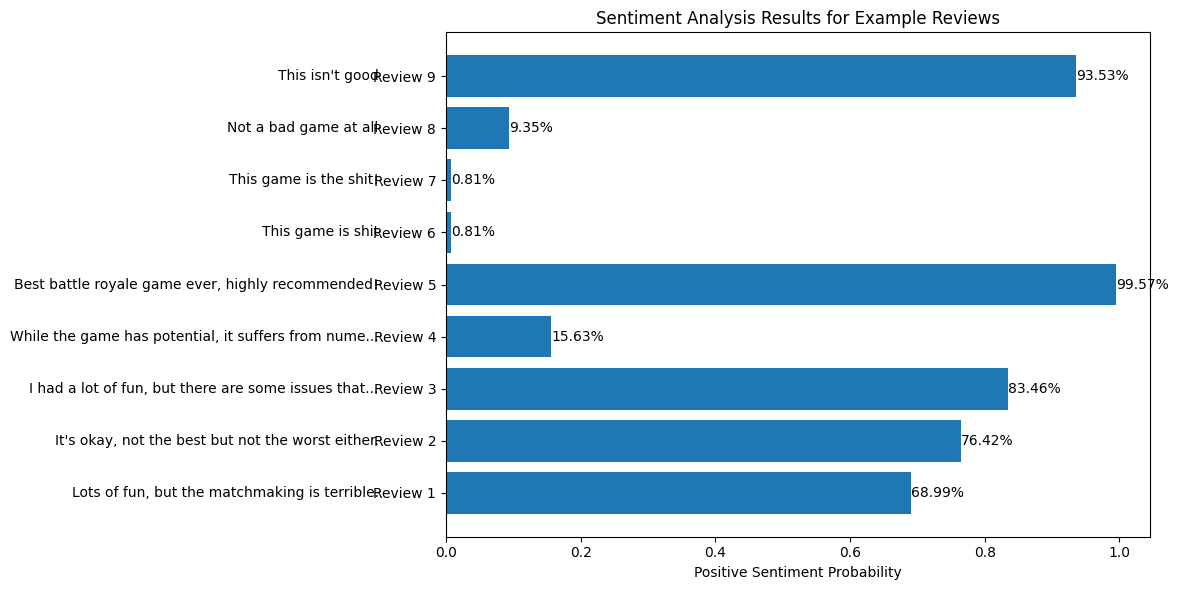

In [8]:
def analyze_sentiment(text: str, model, vectorizer) -> tuple[str, tuple[float, float]]:
    """Analyze the sentiment of a given text using the trained model.

    Returns:
        tuple: (sentiment label, (negative probability, positive probability))
    """
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Vectorize
    text_vectorized = vectorizer.transform([processed_text])

    # Get probabilities
    probs = model.predict_proba(text_vectorized)[0]
    prediction = model.predict(text_vectorized)[0]

    return ('Positive' if prediction else 'Negative', probs)

# Test the analyzer with some example reviews
example_reviews = [
    "Lots of fun, but the matchmaking is terrible.",
    "It's okay, not the best but not the worst either.",
    "I had a lot of fun, but there are some issues that need fixing.",
    "While the game has potential, it suffers from numerous bugs.",
    "Best battle royale game ever, highly recommended!",
    "This game is shit",
    "This game is the shit!",
    "Not a bad game at all",
    "This isn't good",
]

# Analyze example reviews with improved formatting
print("\nSentiment Analysis Results:")
print("-" * 80)
for review in example_reviews:
    sentiment, probs = analyze_sentiment(review, svm_model, tfidf)
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: Negative={probs[0]:.2%}, Positive={probs[1]:.2%}")
    print("-" * 80)

# Visualize the sentiment probabilities for example reviews
fig, ax = plt.subplots(figsize=(12, 6))

# Get probabilities for each review
probs = [analyze_sentiment(review, svm_model, tfidf)[1][1] for review in example_reviews]

# Create bar chart
bars = ax.barh(range(len(example_reviews)), probs)
ax.set_yticks(range(len(example_reviews)))
ax.set_yticklabels([f"Review {i+1}" for i in range(len(example_reviews))])
ax.set_xlabel('Positive Sentiment Probability')
ax.set_title('Sentiment Analysis Results for Example Reviews')

# Add probability values on bars
for i, v in enumerate(probs):
    ax.text(v, i, f'{v:.2%}', va='center')

# Add review text as annotations
for i, review in enumerate(example_reviews):
    ax.text(-0.1, i, review[:50] + '...' if len(review) > 50 else review,
            ha='right', va='center')

plt.tight_layout()
plt.show()

## Model Comparison

Key differences between SVM and Naive Bayes for sentiment analysis:

1. **Decision Boundary**: SVM finds an optimal hyperplane to separate classes, which can handle complex, non-linear decision boundaries better than Naive Bayes
2. **Training Time**: SVM typically takes longer to train than Naive Bayes, especially on large datasets
3. **Memory Usage**: SVM can use more memory than Naive Bayes due to storing support vectors
4. **Feature Independence**: Unlike Naive Bayes, SVM doesn't assume feature independence, which can be beneficial for text analysis where words are often related
5. **Hyperparameter Tuning**: SVM often requires more careful parameter tuning (kernel choice, C parameter, etc.)

The choice between them often depends on:
- Dataset size and complexity
- Available computational resources
- Need for non-linear decision boundaries
- Time constraints for training

## Conclusion

- The SVM model provides a robust way to classify PUBG Steam reviews as positive or negative
- While training takes longer than Naive Bayes, SVM can capture more complex relationships in the text data
- The model shows good performance in handling both clearly positive and negative reviews, as well as more nuanced ones

Further improvements could include:
- Experimenting with different kernels (RBF, polynomial)
- Grid search for optimal hyperparameters
- Using more advanced text preprocessing techniques
- Incorporating n-grams or word embeddings